In [2]:
# ---------- IMPORTS ----------
import os, io, sys, time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

In [3]:
# ---------- DOWNLOAD KOI DATASET ----------
KOI_URL = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&format=csv"

print("Downloading Kepler KOI dataset...")
df = pd.read_csv(KOI_URL)
print(f"Downloaded: {len(df)} rows × {len(df.columns)} columns\n")

Downloaded: 9564 rows × 50 columns



In [4]:
# ---------- TARGET COLUMN DETECTION ----------
disp_cols = [c for c in df.columns if "disposition" in c.lower()]
if not disp_cols:
    raise ValueError("No disposition column found in dataset!")
target_col = disp_cols[0]
print("Disposition column:", target_col)

Disposition column: koi_disposition


In [5]:
# ---------- FEATURE SELECTION ----------
candidate_features = [
    "koi_period", "koi_duration", "koi_depth",
    "koi_prad", "koi_teq", "koi_impact", "koi_ror"
]
features = [f for f in candidate_features if f in df.columns]
if not features:
    features = df.select_dtypes(include=[np.number]).columns[:8].tolist()
print("Using features:", features, "\n")

Using features: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_impact'] 



In [6]:
# ---------- CLEANING ----------
df = df.dropna(subset=[target_col])
df[target_col] = df[target_col].astype(str)

def map_disp(s):
    s = s.strip().upper()
    if "CONFIR" in s:
        return "CONFIRMED"
    elif "CAND" in s or "PC" in s:
        return "CANDIDATE"
    elif "FALSE" in s or "FP" in s:
        return "FALSE_POSITIVE"
    else:
        return "CANDIDATE"

df["label"] = df[target_col].apply(map_disp)
df = df.dropna(subset=features)

# ---------- HANDLE NUMERIC VALUES ----------
X = df[features].apply(pd.to_numeric, errors="coerce")
for c in features:
    X[c].fillna(X[c].median(), inplace=True)
y = df["label"]

/tmp/ipython-input-2020498150.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[c].fillna(X[c].median(), inplace=True)


In [7]:
# ---------- ENCODING & SPLIT ----------
le = LabelEncoder()
y_enc = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# ---------- MODEL TRAINING ----------
print("Training Random Forest model...")
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1)
rf.fit(X_train_s, y_train)

Training Random Forest model...


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)


✅ Model accuracy: 72.24%

                precision    recall  f1-score   support

     CANDIDATE       0.47      0.40      0.43       375
     CONFIRMED       0.71      0.76      0.73       549
FALSE_POSITIVE       0.82      0.83      0.82       917

      accuracy                           0.72      1841
     macro avg       0.67      0.66      0.66      1841
  weighted avg       0.71      0.72      0.72      1841



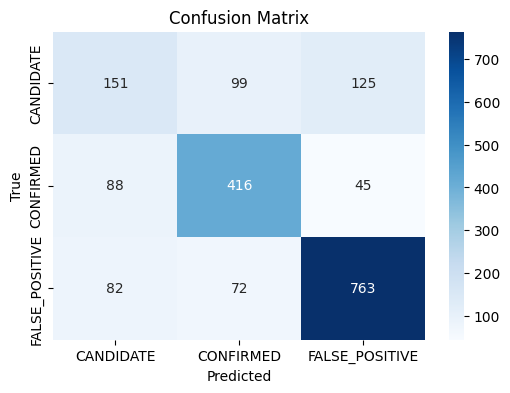

Artifacts saved in ./models



In [8]:
# ---------- EVALUATION ----------
y_pred = rf.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Model accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------- SAVE MODELS ----------
os.makedirs("models", exist_ok=True)
joblib.dump(rf, "models/rf_model.joblib")
joblib.dump(scaler, "models/scaler.joblib")
joblib.dump(le, "models/label_encoder.joblib")
print("Artifacts saved in ./models\n")

In [9]:
# ---------- GRADIO APP ----------
def predict_exoplanet(*vals):
    arr = np.array(vals).reshape(1, -1)
    arr_s = scaler.transform(arr)
    probs = rf.predict_proba(arr_s)[0]
    pred_idx = int(np.argmax(probs))
    label = le.inverse_transform([pred_idx])[0]
    prob_dict = {le.classes_[i]: float(probs[i]) for i in range(len(probs))}
    return label, prob_dict

inputs = [gr.Number(label=f, value=float(X[f].median())) for f in features]
outputs = [
    gr.Label(num_top_classes=3, label="Predicted Class"),
    gr.JSON(label="Class Probabilities")
]

title = "🌌 NASA Exoplanet Classifier"
desc = "AI model trained on Kepler KOI dataset to classify whether an object is a CONFIRMED planet, CANDIDATE, or FALSE POSITIVE."

demo = gr.Interface(fn=predict_exoplanet, inputs=inputs, outputs=outputs, title=title, description=desc)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()


/usr/local/lib/python3.12/dist-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Running on public URL: https://49f39b37d599362aac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
